# Wrangle_act Project

#### Libiraries to be used

In [1]:
import pandas as pd
import numpy as np
import tweepy
import requests
import re
import json
import matplotlib.pyplot as plt
import datetime
import os
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from PIL import Image
from io import BytesIO

## Gathering Data

### We have 3 datasets which will be used in the project:
1. Twitter Acrchive Data (Downloaded file on my PC)

In [2]:
archive_df = pd.read_csv('twitter-archive-enhanced.csv')

2. Image Predictions file (Will be downloaded from a given url)

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = url.split('/')[-1]
response = requests.get(url)
if not os.path.isfile(file_name):
    with open (file_name, 'wb') as f:
        f.write(response.content)

image_prediction = pd.read_csv(file_name, sep='\t')

3. The real data from Twitter API (using Tweepy)

3.1. Taking the authorization to use the tweepy API.

In [4]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

3.2. Getting the required data from Twitter and dumping it in a new file.

In [5]:
errors = []
if not os.path.isfile('tweet_json.txt'):
    # create the file and write on it
    with open ('tweet_json.txt', 'w') as file:
        for tweet_id in archive_df['tweet_id']:
            try:
                status = api.get_status(tweet_id, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, tweet_mode='extended')
                json.dump(status._json, file)
                file.write('\n')
            except Exception as e:
                print("Error on tweet id {}".format(tweet_id) + ";" + str(e))
                errors.append(tweet_id)
len(errors)

0

3.3. Opening the json file and loading its data in a dictionnary to create the dataframe.

In [6]:
status_list = []
with open ('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        tweet_dict = json.loads(line)
        tweet_id = tweet_dict['id']
        retweet_count = tweet_dict['retweet_count']
        fav_count = tweet_dict['favorite_count']
        status_list.append({'tweet_id': tweet_id, 'retweet_count': retweet_count, 'favorite_count': fav_count})
        
api_df = pd.DataFrame(status_list)

## Assessing Data

#### Visual Assessment

In [7]:
# In this record, the dog rating isn't correct.
archive_df[archive_df.tweet_id == 775096608509886464]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None


In [8]:
# The two below records are duplicates.
image_prediction[image_prediction.tweet_id == 819015331746349057]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1717,819015331746349057,https://pbs.twimg.com/media/C12x-JTVIAAzdfl.jpg,4,prison,0.907083,False,palace,0.020089,False,umbrella,0.00785,False


In [9]:
image_prediction[image_prediction.tweet_id == 819006400881917954]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1716,819006400881917954,https://pbs.twimg.com/media/C12x-JTVIAAzdfl.jpg,4,prison,0.907083,False,palace,0.020089,False,umbrella,0.00785,False


In [10]:
api_df.sample(20)

,tweet_id,retweet_count,favorite_count
995,746757706116112384,3821,9390
1991,672125275208069120,1074,2258
1002,746056683365994496,796,3506
1286,707021089608753152,1317,3984
1640,682697186228989953,354,1287
1186,715360349751484417,1516,5326
1682,680798457301471234,1002,2766
1084,733828123016450049,757,3495
2015,671536543010570240,376,1107
1846,675135153782571009,450,1244


#### Programmatic Assessment 

In [11]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [12]:
archive_df.name.value_counts()

None       745
a           55
Charlie     12
Lucy        11
Cooper      11
          ... 
Lucky        1
Beya         1
Joshwa       1
Molly        1
Stormy       1
Name: name, Length: 957, dtype: int64

In [13]:
archive_df[archive_df.name.str.islower()].name.value_counts()

a               55
the              8
an               7
very             5
quite            4
just             4
one              4
getting          2
mad              2
actually         2
not              2
his              1
incredibly       1
old              1
such             1
space            1
by               1
life             1
officially       1
my               1
infuriating      1
all              1
unacceptable     1
light            1
this             1
Name: name, dtype: int64

In [14]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [15]:
image_prediction.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
canoe                   1
long-horned_beetle      1
pot                     1
studio_couch            1
book_jacket             1
Name: p1, Length: 378, dtype: int64

In [16]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2328 non-null   int64
 1   retweet_count   2328 non-null   int64
 2   favorite_count  2328 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


In [17]:
api_df.tweet_id.duplicated().sum()

0

### Twitter Archive Data (archive_df) Quality Issues:
- **Wrong data types** (tweet_id, timestamp)
- **Missing names** ;name = a, none. Some actual names are in text after 'named' or 'name is '
- **Inaccurate Rating_denominator** some records don't equal 10 are manually corrected
- **Inaccurate Rating_nomerator** record above 100 are corrected to 100 to decrease the date skewing
- **Data with retweets and replies** shouldn't be included in all dataframes
- **Missing expanded urls** for tweets without photos, can be dropped

In [18]:
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Image Predictcions (image_prediction) Quality Issues:
- **Wrong data types** (tweet_id)
- **False records of predictions** with record of p1_dog = website & (p1=False, p2=False, p3=False)
- **Missing Tweets with no images** archive_df rows = 2356, image_prediction rows = 2075, api_df rows = 2328
- **jpg_url column has duplicates**

In [19]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2328 non-null   int64
 1   retweet_count   2328 non-null   int64
 2   favorite_count  2328 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


### Twitter API Data (api_df) Quality Issues:
- **Wrong data type** (tweet_id)

### Tidiness Issues:
- The 3 dataframes needs to be merged into one dataframe with one tweet_id column
- In archive_df, Columns are values (doggo, floofer, pupper, puppo); melting required

## Cleaning Data

In [20]:
archive_copy = archive_df.copy()
prediction_copy = image_prediction.copy()
api_copy = api_df.copy()

#### Define (1)

1. Replace the 'none' and 'a' with the name which might be present in tweet text, else replace with NaN
2. Remove all invalid dog names (setting lowercase names as NaN)

#### Code

Identifying a pattern for finding the actual names in tweet text.
Iterating through the archive_copy and finding the names with 'a' and 'None' and replacing them with the actual names.
If no names, then replace with NaN

In [21]:
pattern = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in archive_copy.iterrows():
    try:
        if row['name'] == 'a':
            c_name = re.findall(pattern, row['text'])[0]
            archive_copy.loc[index, 'name'] = archive_copy.loc[index, 'name'].replace('a', c_name)
        elif row['name'] == 'an':
            c_name = re.findall(pattern, row['text'])[0]
            archive_copy.loc[index, 'name'] = archive_copy.loc[index, 'name'].replace('an', c_name)
        elif row['name'] == 'None':
            c_name = re.findall(pattern, row['text'])[0]
            archive_copy.loc[index, 'name'] = archive_copy.loc[index, 'name'].replace('None', c_name)
    except IndexError:
        archive_copy.loc[index, 'name'] = np.nan

In [22]:
archive_copy.loc[archive_copy.name.str.islower().fillna(False),'name'] = np.nan

#### Test

In [23]:
archive_copy[archive_copy.name.str.islower().fillna(False)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [24]:
archive_copy.name.value_counts(dropna = False)

NaN           823
Charlie        12
Cooper         11
Lucy           11
Oliver         11
             ... 
Daryl           1
Rorie           1
Shiloh          1
Aja             1
Christoper      1
Name: name, Length: 957, dtype: int64

#### Define (2)

Removing the NaN values of expanded url column

#### Code

In [25]:
archive_copy.expanded_urls.dropna(axis = 0, inplace=True)

#### Test

In [26]:
archive_copy.expanded_urls.isna().sum()

0

In [27]:
archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        1533 non-null   object 
 13  doggo                       2356 

#### Define (3)

1. Removing the data with retweets and replies from the archive_copy as they are not original tweets.
2. Removing the columns (source) as it is not needed.

#### Code

In [28]:
archive_copy = archive_copy[archive_copy.retweeted_status_id.isnull()]

In [29]:
archive_copy.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'source'], inplace=True)

#### Test

In [30]:
archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   int64 
 1   timestamp           2175 non-null   object
 2   text                2175 non-null   object
 3   expanded_urls       2117 non-null   object
 4   rating_numerator    2175 non-null   int64 
 5   rating_denominator  2175 non-null   int64 
 6   name                1421 non-null   object
 7   doggo               2175 non-null   object
 8   floofer             2175 non-null   object
 9   pupper              2175 non-null   object
 10  puppo               2175 non-null   object
dtypes: int64(3), object(8)
memory usage: 203.9+ KB


#### Define (4)

New column named 'stage' as catergorial variable to substitute the 4 stages columns of dogs (doggo, floofer, pupper, puppo)

#### Code

In [31]:
archive_copy.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,None,None,None,None,1831
1,None,None,None,puppo,24
2,None,None,pupper,None,224
3,None,floofer,None,None,9
4,doggo,None,None,None,75
5,doggo,None,None,puppo,1
6,doggo,None,pupper,None,10
7,doggo,floofer,None,None,1


In [32]:
archive_copy.doggo.replace('None', '', inplace=True)
archive_copy.doggo.replace(np.NaN, '', inplace=True)
archive_copy.pupper.replace('None', '', inplace=True)
archive_copy.pupper.replace(np.NaN, '', inplace=True)
archive_copy.puppo.replace('None', '', inplace=True)
archive_copy.puppo.replace(np.NaN, '', inplace=True)
archive_copy.floofer.replace('None', '', inplace=True)
archive_copy.floofer.replace(np.NaN, '', inplace=True)

In [33]:
archive_copy['stage'] = archive_copy.doggo + archive_copy.floofer + archive_copy.pupper + archive_copy.puppo
archive_copy.loc[archive_copy.stage == 'doggopupper', 'stage'] = 'doggo, pupper'
archive_copy.loc[archive_copy.stage == 'doggopuppo', 'stage'] = 'doggo, puppo'
archive_copy.loc[archive_copy.stage == 'doggofloofer', 'stage'] = 'doggo, floofer'

In [34]:
archive_copy.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)
archive_copy = archive_copy.sort_values('stage').drop_duplicates(subset=['tweet_id'], keep='last')
archive_copy.stage = archive_copy.stage.astype('category')

#### Test

In [35]:
archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 168
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   tweet_id            2175 non-null   int64   
 1   timestamp           2175 non-null   object  
 2   text                2175 non-null   object  
 3   expanded_urls       2117 non-null   object  
 4   rating_numerator    2175 non-null   int64   
 5   rating_denominator  2175 non-null   int64   
 6   name                1421 non-null   object  
 7   stage               2175 non-null   category
dtypes: category(1), int64(3), object(4)
memory usage: 138.4+ KB


In [36]:
archive_copy.stage.value_counts()

                  1831
pupper             224
doggo               75
puppo               24
doggo, pupper       10
floofer              9
doggo, puppo         1
doggo, floofer       1
Name: stage, dtype: int64

#### Define (5)

Extract ratings with numerators and denomirators with decimels.

#### Code

In [37]:
ratings = archive_copy.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True).astype(float)

In [38]:
archive_copy.rating_numerator = ratings[0]

In [39]:
archive_copy.rating_denominator = ratings[1]

#### Test

In [40]:
archive_copy.rating_numerator.sample(5)

1667    11.0
731     11.0
505     10.0
1582    11.0
1095    13.0
Name: rating_numerator, dtype: float64

In [41]:
archive_copy.rating_denominator.sample(5)

1936    10.0
2192    10.0
571     10.0
2294    10.0
1469    10.0
Name: rating_denominator, dtype: float64

In [42]:
archive_copy[archive_copy.tweet_id == 786709082849828864]

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,stage
695,786709082849828864,2016-10-13 23:23:56 +0000,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,9.75,10.0,Logan,


#### Define (6)

Merging the 3 dataframes into one dataframe named df_merged:
1. Merging archive_copy and predictions_copy
2. Merging df-merged and api_copy
3. Dealing with tweets with no images by merging on tweet_id on archive_copy

#### Code

In [43]:
df_merged = pd.merge(archive_copy, prediction_copy, on='tweet_id', how='inner')

In [44]:
df_merged = pd.merge(df_merged, api_copy, on='tweet_id', how='inner')

#### Test

In [45]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1984 entries, 0 to 1983
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   tweet_id            1984 non-null   int64   
 1   timestamp           1984 non-null   object  
 2   text                1984 non-null   object  
 3   expanded_urls       1984 non-null   object  
 4   rating_numerator    1984 non-null   float64 
 5   rating_denominator  1984 non-null   float64 
 6   name                1370 non-null   object  
 7   stage               1984 non-null   category
 8   jpg_url             1984 non-null   object  
 9   img_num             1984 non-null   int64   
 10  p1                  1984 non-null   object  
 11  p1_conf             1984 non-null   float64 
 12  p1_dog              1984 non-null   bool    
 13  p2                  1984 non-null   object  
 14  p2_conf             1984 non-null   float64 
 15  p2_dog              1984 non-null   bo

#### Define (7)

Drop duplicates of jpg_url

#### Code

In [46]:
df_merged.drop_duplicates(subset=['jpg_url'], inplace=True)

#### Test

In [47]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1984 entries, 0 to 1983
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   tweet_id            1984 non-null   int64   
 1   timestamp           1984 non-null   object  
 2   text                1984 non-null   object  
 3   expanded_urls       1984 non-null   object  
 4   rating_numerator    1984 non-null   float64 
 5   rating_denominator  1984 non-null   float64 
 6   name                1370 non-null   object  
 7   stage               1984 non-null   category
 8   jpg_url             1984 non-null   object  
 9   img_num             1984 non-null   int64   
 10  p1                  1984 non-null   object  
 11  p1_conf             1984 non-null   float64 
 12  p1_dog              1984 non-null   bool    
 13  p2                  1984 non-null   object  
 14  p2_conf             1984 non-null   float64 
 15  p2_dog              1984 non-null   bo

#### Define (8)

Remove wrong records of p1 = 'web_site'

#### Code

In [48]:
to_drop = df_merged[df_merged.p1 == 'web_site'].index
df_merged.drop(to_drop, axis=0, inplace=True)

#### Test

In [49]:
df_merged[df_merged.p1 == 'web_site']

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count


In [50]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 1983
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   tweet_id            1969 non-null   int64   
 1   timestamp           1969 non-null   object  
 2   text                1969 non-null   object  
 3   expanded_urls       1969 non-null   object  
 4   rating_numerator    1969 non-null   float64 
 5   rating_denominator  1969 non-null   float64 
 6   name                1366 non-null   object  
 7   stage               1969 non-null   category
 8   jpg_url             1969 non-null   object  
 9   img_num             1969 non-null   int64   
 10  p1                  1969 non-null   object  
 11  p1_conf             1969 non-null   float64 
 12  p1_dog              1969 non-null   bool    
 13  p2                  1969 non-null   object  
 14  p2_conf             1969 non-null   float64 
 15  p2_dog              1969 non-null   bo

#### Define (9)

Manually correcting denominators != 10 

#### Code

In [51]:
df_merged[df_merged.rating_denominator != 10]

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
34,684222868335505415,2016-01-05 04:00:18 +0000,Someone help the girl is being mugged. Several...,https://twitter.com/dog_rates/status/684222868...,121.0,110.0,NaN,,https://pbs.twimg.com/media/CX7Y_ByWwAEJdUy.jpg,1,...,0.791182,True,cocker_spaniel,0.072444,True,teddy,0.071486,False,1327,3738
35,684225744407494656,2016-01-05 04:11:44 +0000,"Two sneaky puppers were not initially seen, mo...",https://twitter.com/dog_rates/status/684225744...,143.0,130.0,NaN,,https://pbs.twimg.com/media/CX7br3HWsAAQ9L1.jpg,2,...,0.203249,True,Samoyed,0.067958,True,Great_Pyrenees,0.065327,True,201,1206
161,677716515794329600,2015-12-18 05:06:23 +0000,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,https://twitter.com/dog_rates/status/677716515...,144.0,120.0,NaN,,https://pbs.twimg.com/media/CWe7kw9W4AE8UJh.jpg,1,...,0.662908,False,crib,0.031891,False,chow,0.025438,True,942,2945
187,682962037429899265,2016-01-01 16:30:13 +0000,This is Darrel. He just robbed a 7/11 and is i...,https://twitter.com/dog_rates/status/682962037...,7.0,11.0,Darrel,,https://pbs.twimg.com/media/CXpeVzQW8AApKYb.jpg,1,...,0.278600,False,Chihuahua,0.155207,True,loupe,0.153598,False,16030,35875
238,709198395643068416,2016-03-14 02:04:08 +0000,"From left to right:\nCletus, Jerome, Alejandro...",https://twitter.com/dog_rates/status/709198395...,45.0,50.0,NaN,,https://pbs.twimg.com/media/CdeUKpcWoAAJAWJ.jpg,1,...,0.490783,True,wire-haired_fox_terrier,0.083513,True,English_setter,0.083184,True,624,2385
294,716439118184652801,2016-04-03 01:36:11 +0000,This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50.0,50.0,Bluebert,,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg,1,...,0.396495,True,malamute,0.317053,True,Eskimo_dog,0.273419,True,203,2324
306,710658690886586372,2016-03-18 02:46:49 +0000,Here's a brigade of puppers. All look very pre...,https://twitter.com/dog_rates/status/710658690...,80.0,80.0,NaN,,https://pbs.twimg.com/media/CdzETn4W4AAVU5N.jpg,1,...,0.948617,True,Dandie_Dinmont,0.018664,True,cairn,0.015943,True,545,2252
328,713900603437621249,2016-03-27 01:29:02 +0000,Happy Saturday here's 9 puppers on a bench. 99...,https://twitter.com/dog_rates/status/713900603...,99.0,90.0,NaN,,https://pbs.twimg.com/media/CehIzzZWQAEyHH5.jpg,1,...,0.371816,True,cocker_spaniel,0.177413,True,Irish_setter,0.092725,True,716,2768
342,697463031882764288,2016-02-10 16:51:59 +0000,Happy Wednesday here's a bucket of pups. 44/40...,https://twitter.com/dog_rates/status/697463031...,44.0,40.0,NaN,,https://pbs.twimg.com/media/Ca3i7CzXIAMLhg8.jpg,1,...,0.999885,True,golden_retriever,0.000098,True,pug,0.000008,True,1372,3344
397,704054845121142784,2016-02-28 21:25:30 +0000,Here is a whole flock of puppers. 60/50 I'll ...,https://twitter.com/dog_rates/status/704054845...,60.0,50.0,NaN,,https://pbs.twimg.com/media/CcVOJEcXEAM0FHL.jpg,1,...,0.667939,True,kuvasz,0.228764,True,golden_retriever,0.043885,True,895,2849


In [52]:
# The tweet index 34 is a modified tweet of index 35
df_merged.drop(index = 34, inplace = True)

In [53]:
df_merged.loc[df_merged.tweet_id == 684225744407494656, ['rating_numerator']] = 11

In [54]:
df_merged.loc[df_merged.tweet_id == 684225744407494656, ['rating_denominator']] = 10

In [55]:
df_merged.loc[df_merged.tweet_id == 677716515794329600, ['rating_numerator']] = 12

In [56]:
df_merged.loc[df_merged.tweet_id == 677716515794329600, ['rating_denominator']] = 10

In [57]:
df_merged.loc[df_merged.tweet_id == 682962037429899265, ['rating_numerator']] = 10

In [58]:
df_merged.loc[df_merged.tweet_id == 682962037429899265, ['rating_denominator']] = 10

In [59]:
df_merged.loc[df_merged.tweet_id == 709198395643068416, ['rating_numerator']] = 9

In [60]:
df_merged.loc[df_merged.tweet_id == 709198395643068416, ['rating_denominator']] = 10

In [61]:
df_merged.loc[df_merged.tweet_id == 716439118184652801, ['rating_numerator']] = 11

In [62]:
df_merged.loc[df_merged.tweet_id == 716439118184652801, ['rating_denominator']] = 10

In [63]:
df_merged.loc[df_merged.tweet_id == 710658690886586372, ['rating_numerator']] = 10

In [64]:
df_merged.loc[df_merged.tweet_id == 710658690886586372, ['rating_denominator']] = 10

In [65]:
df_merged.loc[df_merged.tweet_id == 713900603437621249, ['rating_numerator']] = 11

In [66]:
df_merged.loc[df_merged.tweet_id == 713900603437621249, ['rating_denominator']] = 10

In [67]:
df_merged.loc[df_merged.tweet_id == 697463031882764288, ['rating_numerator']] = 11

In [68]:
df_merged.loc[df_merged.tweet_id == 697463031882764288, ['rating_denominator']] = 10

In [69]:
df_merged.loc[df_merged.tweet_id == 704054845121142784, ['rating_numerator']] = 12

In [70]:
df_merged.loc[df_merged.tweet_id == 704054845121142784, ['rating_denominator']] = 10

In [71]:
df_merged.loc[df_merged.tweet_id == 666287406224695296, ['rating_numerator']] = 9

In [72]:
df_merged.loc[df_merged.tweet_id == 666287406224695296, ['rating_denominator']] = 10

In [73]:
df_merged.loc[df_merged.tweet_id == 675853064436391936, ['rating_numerator']] = 11

In [74]:
df_merged.loc[df_merged.tweet_id == 675853064436391936, ['rating_denominator']] = 10

In [75]:
# The tweet index 982 has no ratings
df_merged.drop(index = 982, inplace = True)

In [76]:
df_merged.loc[df_merged.tweet_id == 820690176645140481, ['rating_numerator']] = 12

In [77]:
df_merged.loc[df_merged.tweet_id == 820690176645140481, ['rating_denominator']] = 10

In [78]:
df_merged.loc[df_merged.tweet_id == 758467244762497024, ['rating_numerator']] = 11

In [79]:
df_merged.loc[df_merged.tweet_id == 758467244762497024, ['rating_denominator']] = 10

In [80]:
df_merged.loc[df_merged.tweet_id == 731156023742988288, ['rating_numerator']] = 12

In [81]:
df_merged.loc[df_merged.tweet_id == 731156023742988288, ['rating_denominator']] = 10

In [82]:
df_merged.loc[df_merged.tweet_id == 722974582966214656, ['rating_numerator']] = 13

In [83]:
df_merged.loc[df_merged.tweet_id == 722974582966214656, ['rating_denominator']] = 10

In [84]:
df_merged.loc[df_merged.tweet_id == 740373189193256964, ['rating_numerator']] = 14

In [85]:
df_merged.loc[df_merged.tweet_id == 740373189193256964, ['rating_denominator']] = 10

#### Test

In [86]:
df_merged[df_merged.rating_denominator != 10]

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count


#### Define (10)

1. Creating a column named 'rating' = numerator
2. Removing both numerators and denominators columns as rating will be used instead.

In [87]:
df_merged['rating'] = df_merged['rating_numerator']
df_merged.rating = df_merged.rating.astype('int64')
df_merged.drop(['rating_numerator', 'rating_denominator'], axis=1 , inplace=True)

#### Test

In [88]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 1983
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   tweet_id        1967 non-null   int64   
 1   timestamp       1967 non-null   object  
 2   text            1967 non-null   object  
 3   expanded_urls   1967 non-null   object  
 4   name            1365 non-null   object  
 5   stage           1967 non-null   category
 6   jpg_url         1967 non-null   object  
 7   img_num         1967 non-null   int64   
 8   p1              1967 non-null   object  
 9   p1_conf         1967 non-null   float64 
 10  p1_dog          1967 non-null   bool    
 11  p2              1967 non-null   object  
 12  p2_conf         1967 non-null   float64 
 13  p2_dog          1967 non-null   bool    
 14  p3              1967 non-null   object  
 15  p3_conf         1967 non-null   float64 
 16  p3_dog          1967 non-null   bool    
 17  retweet_count 

In [89]:
df_merged.sample(5)

,tweet_id,timestamp,text,expanded_urls,name,stage,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,rating
1060,788150585577050112,2016-10-17 22:51:57 +0000,This is Leo. He's a golden chow. Rather h*ckin...,https://twitter.com/dog_rates/status/788150585...,Leo,,https://pbs.twimg.com/media/CvASw6dWcAQmo3X.jpg,3,chow,0.814145,True,Pomeranian,0.112704,True,Chihuahua,0.015883,True,1283,6126,13
1031,820690176645140481,2017-01-15 17:52:40 +0000,The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,NaN,,https://pbs.twimg.com/media/C2OtWr0VQAEnS9r.jpg,2,West_Highland_white_terrier,0.872064,True,kuvasz,0.059526,True,Samoyed,0.037400,True,3201,12167,12
175,682047327939461121,2015-12-30 03:55:29 +0000,We normally don't rate bears but this one seem...,https://twitter.com/dog_rates/status/682047327...,Thea,,https://pbs.twimg.com/media/CXcebTeWsAUQJ-J.jpg,1,teddy,0.364095,False,doormat,0.119243,False,toyshop,0.035127,False,917,3115,10
1333,853299958564483072,2017-04-15 17:32:18 +0000,This is Rumpole. He'll be your Uber driver thi...,https://twitter.com/dog_rates/status/853299958...,Rumpole,,https://pbs.twimg.com/media/C9eHyF7XgAAOxPM.jpg,1,grille,0.652280,False,beach_wagon,0.112846,False,convertible,0.086252,False,3386,14882,13
780,675798442703122432,2015-12-12 22:04:39 +0000,This is Bernie. He just touched a boob for the...,https://twitter.com/dog_rates/status/675798442...,Bernie,,https://pbs.twimg.com/media/CWDrGH4UYAARoq_.jpg,1,beagle,0.681218,True,basset,0.125121,True,boxer,0.080398,True,3273,9824,10


#### Define (11)

Removing unneeded columns; expanded_urls, jpg_url, img_num

#### Code

In [90]:
df_merged.drop(['expanded_urls', 'jpg_url', 'img_num'], axis=1, inplace=True)

#### Test

In [91]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 1983
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   tweet_id        1967 non-null   int64   
 1   timestamp       1967 non-null   object  
 2   text            1967 non-null   object  
 3   name            1365 non-null   object  
 4   stage           1967 non-null   category
 5   p1              1967 non-null   object  
 6   p1_conf         1967 non-null   float64 
 7   p1_dog          1967 non-null   bool    
 8   p2              1967 non-null   object  
 9   p2_conf         1967 non-null   float64 
 10  p2_dog          1967 non-null   bool    
 11  p3              1967 non-null   object  
 12  p3_conf         1967 non-null   float64 
 13  p3_dog          1967 non-null   bool    
 14  retweet_count   1967 non-null   int64   
 15  favorite_count  1967 non-null   int64   
 16  rating          1967 non-null   int64   
dtypes: bool(3), ca

#### Define (12)

Changing wrong datatypes of columns:
- tweet_id --> string
- timestamp --> datetime

#### Code

In [92]:
df_merged.tweet_id = df_merged.tweet_id.astype('object')
df_merged.timestamp = pd.to_datetime(df_merged.timestamp)

#### Test

In [93]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 1983
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        1967 non-null   object             
 1   timestamp       1967 non-null   datetime64[ns, UTC]
 2   text            1967 non-null   object             
 3   name            1365 non-null   object             
 4   stage           1967 non-null   category           
 5   p1              1967 non-null   object             
 6   p1_conf         1967 non-null   float64            
 7   p1_dog          1967 non-null   bool               
 8   p2              1967 non-null   object             
 9   p2_conf         1967 non-null   float64            
 10  p2_dog          1967 non-null   bool               
 11  p3              1967 non-null   object             
 12  p3_conf         1967 non-null   float64            
 13  p3_dog          1967 non-null   b

#### Define (13)

1. Deleting the underscore from the p1, p2 and p3.
2. Making the dog names titled.

#### Code

In [94]:
df_merged.p1 = df_merged.p1.str.replace('_', ' ')
df_merged.p1 = df_merged.p1.str.title()

In [95]:
df_merged.p2 = df_merged.p2.str.replace('_', ' ')
df_merged.p2 = df_merged.p2.str.title()

In [96]:
df_merged.p3 = df_merged.p3.str.replace('_', ' ')
df_merged.p3 = df_merged.p3.str.title()

#### Test

In [97]:
df_merged.p1

0                     Orange
1             Siberian Husky
2                  Damselfly
3                 Great Dane
4                 Pomeranian
                ...         
1979    Old English Sheepdog
1980       Italian Greyhound
1981              Rottweiler
1982      Miniature Pinscher
1983        Golden Retriever
Name: p1, Length: 1967, dtype: object

## Storing

Storing the cleaned dataframe to a file named "twitter_archive_master.csv"

In [98]:
df_merged.to_csv('twitter_archive_master.csv')

## Analyzing

#### Insight (1)

In [99]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 1983
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        1967 non-null   object             
 1   timestamp       1967 non-null   datetime64[ns, UTC]
 2   text            1967 non-null   object             
 3   name            1365 non-null   object             
 4   stage           1967 non-null   category           
 5   p1              1967 non-null   object             
 6   p1_conf         1967 non-null   float64            
 7   p1_dog          1967 non-null   bool               
 8   p2              1967 non-null   object             
 9   p2_conf         1967 non-null   float64            
 10  p2_dog          1967 non-null   bool               
 11  p3              1967 non-null   object             
 12  p3_conf         1967 non-null   float64            
 13  p3_dog          1967 non-null   b

- The data started at 2356 records and ended with 1967 record which means that 389 records needed to be cleaned (about 16.5%).
- A lot of columns were removed as they were not useful in the analysis.
- Some missing information like the name of the dogs were extracted from the tweet’s text, so it was quite important to have the tweet’s text data archived.

#### Insight (2)

In [100]:
df_merged.describe()

,p1_conf,p2_conf,p3_conf,retweet_count,favorite_count,rating
count,1967.000000,1.967000e+03,1.967000e+03,1967.000000,1967.000000,1967.000000
mean,0.591357,1.353733e-01,6.069287e-02,2385.213015,8073.813421,11.650737
std,0.271526,1.005144e-01,5.087561e-02,4289.229513,11947.995630,40.915758
min,0.044333,1.011300e-08,1.740170e-10,11.000000,70.000000,0.000000
25%,0.360294,5.489420e-02,1.667530e-02,538.000000,1726.000000,10.000000
50%,0.586307,1.186510e-01,5.000780e-02,1149.000000,3630.000000,11.000000
75%,0.841043,1.957615e-01,9.233995e-02,2698.000000,10049.000000,12.000000
max,1.000000,4.880140e-01,2.734190e-01,75939.000000,153277.000000,1776.000000


- There is a very big gap between the max. and the third quartile of the retweet and favorite counts data (max. 75,939 and 75% of 2,698) which leads that most of the dogs images were ok. However less than 25% were tremendously perfect.
- The image prediction file results are very logic as the min. rating, retweet and favorite counts were corresponding to very low predictions.
- The rating system doesn’t really describe if the users really like a dog; for example:
    - The mean of the favorite counts was 8,073 while the max. was 153,277 (the mean was about 5% of the max.)
    - The mean of the retweet counts was 2,385 while the max. was 75,939 (the mean was about 3% of the max.)

#### Insight (3)

In [101]:
df_merged.p1.value_counts()

Golden Retriever      137
Labrador Retriever     93
Pembroke               88
Chihuahua              79
Pug                    54
                     ... 
Cup                     1
Japanese Spaniel        1
Pedestal                1
Cliff                   1
Marmot                  1
Name: p1, Length: 373, dtype: int64

- The max. loved dog type as per the high predictions was Golden Retriever

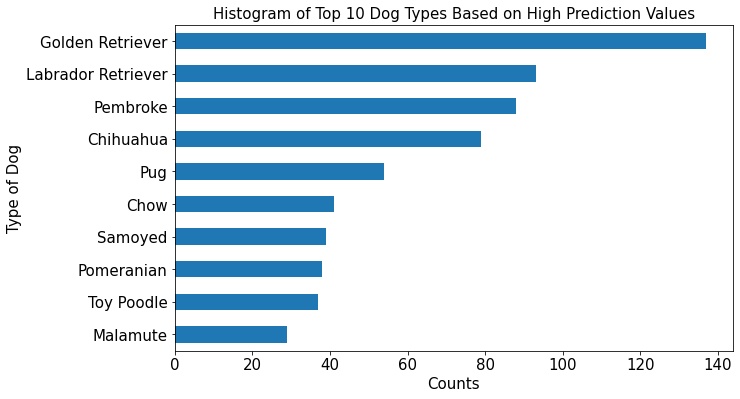

In [102]:
df_merged.p1.value_counts()[9::-1].plot(kind='barh', figsize=(10,6), fontsize=15);
plt.title('Histogram of Top 10 Dog Types Based on High Prediction Values', fontsize=15);
plt.xlabel('Counts', fontsize=15);
plt.ylabel('Type of Dog', fontsize=15);

In [103]:
df_merged.p2.value_counts()

Labrador Retriever          95
Golden Retriever            81
Cardigan                    73
Chihuahua                   42
Chesapeake Bay Retriever    40
                            ..
Handkerchief                 1
Gila Monster                 1
Waffle Iron                  1
Pelican                      1
Home Theater                 1
Name: p2, Length: 394, dtype: int64

- The max. loved dog type as per the medium predictions was Labrador Retriever

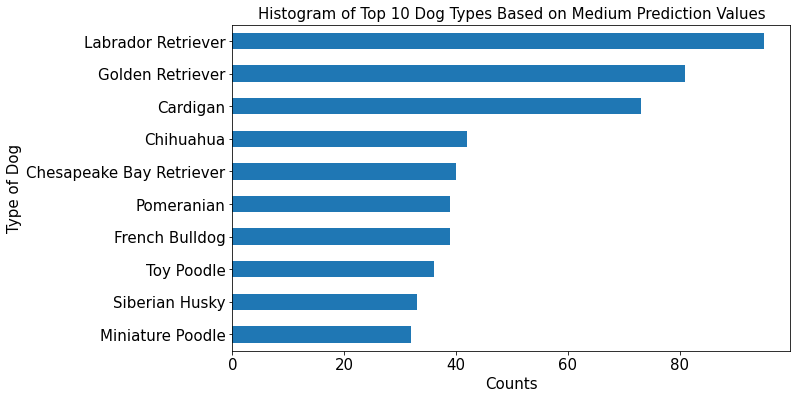

In [104]:
df_merged.p2.value_counts()[9::-1].plot(kind='barh', figsize=(10,6), fontsize=15);
plt.title('Histogram of Top 10 Dog Types Based on Medium Prediction Values', fontsize=15);
plt.xlabel('Counts', fontsize=15);
plt.ylabel('Type of Dog', fontsize=15);

In [105]:
df_merged.p3.value_counts()

Labrador Retriever    74
Chihuahua             56
Golden Retriever      44
Eskimo Dog            36
Kelpie                33
                      ..
Chime                  1
Orangutan              1
Badger                 1
Grey Fox               1
Wing                   1
Name: p3, Length: 397, dtype: int64

- The max. loved dog type as per the low predictions was also Labrador Retriever

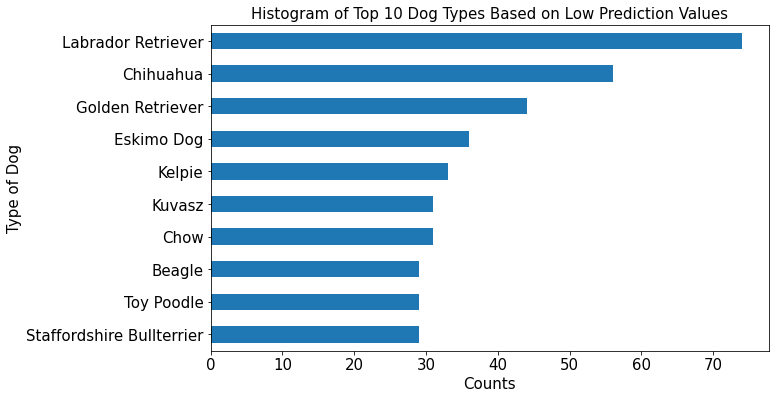

In [106]:
df_merged.p3.value_counts()[9::-1].plot(kind='barh', figsize=(10,6), fontsize=15);
plt.title('Histogram of Top 10 Dog Types Based on Low Prediction Values', fontsize=15);
plt.xlabel('Counts', fontsize=15);
plt.ylabel('Type of Dog', fontsize=15);